In this post we'll explore linear separability further, searching for the 'best' separating boundary between our two classes. After that we'll look into an extension of the concept, which will allow us separate classes which aren't even linearly separable.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cvxopt as cvx
from functools import partial
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from utils import *

First, lets load our Iris dataset again. In the previous [post](lin-1.html), we found several ways of finding a separating hyperplane. Well, it was just a line, but hyper sounds way better. The question we'll try to answer now is how to choose the best hyperplane, and how to go about defining what's 'best'.

In [3]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
t = iris.target
idx_setosa = (t == 0)
t[ idx_setosa] =  1
t[~idx_setosa] = -1
# make the separation bigger by 'editing' a straggler 
X[(X[:, 0] < 4.6) & (X[:, 1] < 2.5)] += np.array([[0, 0.5, 0, 0]])

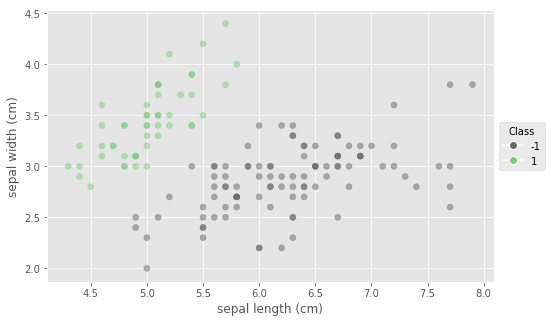

In [4]:
fig, ax = plot_scatter(X, t, [0, 1],
                       xlabel=iris.feature_names[0],
                       ylabel=iris.feature_names[1])
add_legend(ax, t)

# Hard margin SVM

In the previous [post](lin-1.html) we used `cvxopt` to solve a bogus quadratic optimisation. Our objective was simply a constant function, since we just cared about satisfying our inequality constraints - expressions of the requirement that each data point must lie on the correct side of the boundary. But then we wondered, how about using this power for good? Instead of just trying to satisfy the constraints, let's do that _and_ find a better separating linear boundary at the same time.

Enter the _hard margin_ SVM. We're way back in the 60'[s](http://www.svms.org/history.html). Bob Dylan's _Freewheelin_' is blowing in the wind.

SVM is an acronym for _support vector machines_. Rest assured, there will be no machines involved. Support vectors, yes, but usually very few of them. They refer to select data points from our training set which are closest to the separating hyperplane with the largest possible margin.

To derive the large margin objective, notice that the distance of any point $\mathbf{x}_n$ to the hyperplane is
$$\dfrac{\left|y(\mathbf{x}_n) \right|}{\|\mathbf{w}\|},$$ 
where $y(\mathbf{x}_n)  = \mathbf{w}^T \mathbf{x}_n + b$.

The _margin_ is defined as the distance from the decision boundary to the _closest_ vector $\mathbf{x}_n$, namely:
$$\min\limits_n \dfrac{\left|y(\mathbf{x}_n) \right|}{\|\mathbf{w}\|}.$$

It is reasonable to expect that the decision boundary that maximises the margin:

$$\text{arg}\max\limits_{\mathbf{w}, b} \left\{ \dfrac{1}{\|\mathbf{w}\|}\min\limits_n\left[ t_n  (\mathbf{w}^T \phi(\mathbf{x}_n) + b)\right]  \right\},$$

would endow good generalisation properties to our classifier; this is indeed justified by [Statistical Learning Theory](https://en.wikipedia.org/wiki/Statistical_Learning_Theory) (see e.g. Vapnik's _The Nature of Statistical Learning Theory_, or check out Abu Mostafa's _Learning from Data_ [lectures](https://work.caltech.edu/telecourse.html)).

We'll rescale both $\mathbf{w}$ and $b$ (an operation which doesn't affect the position of the hyperplane) to get the objective in a simpler form. Insisting that support vectors satisfy $t_n y(\mathbf{x}_n) = 1$, we end up with the following simple formula for the margin: $\dfrac{1}{\|\mathbf{w}\|}$. 

Instead of maximising the margin directly, let's opt for minimising its reciprocal. Or even better, the square of the reciprocal: $\|\mathbf{w}\|^2$. Both objectives are optimised by the same value of $\mathbf{w}$ but the latter one has the nice property being convex, so we can use `cvxopt`. 

We'll use it to solve:

$$ \text{minimise}\quad \dfrac{1}{2}\| \mathbf{w} \|^2, \quad \text{s.t.}$$
$$t_n(\mathbf{w}^T \mathbf{x}_n + b) \ge 1 \quad \text{for all} \hspace{0.5em} n,$$

where the $\frac{1}{2}$ factor in front has no effect other than to make the maths a little bit cleaner by cancelling the $2$ we get when taking the derivative of $\|\mathbf{w}\|^2$.

<!--
Using the Lagrange formulation, the objective to minimise can be written as:
$$
L(\mathbf{w}, b, \mathbf{a}) = \dfrac{1}{2}\|\mathbf{w}\|^2 - \sum\limits_{n=1}^{N} a_n \{t_n (\mathbf{w}^T \mathbf{\phi}(\mathbf{x}_n) + b) - 1\}
$$
with $a_n \geq 0, \forall n$. 
-->

To make our optimisation compatible with `cvxopt`s quadratic solver's API:

```
                minimise    (1/2)*x'*P*x + q'*x 
                subject to  G*x <= h      
                            A*x = b.
```

we'll have to rewrite it in the equivalent formulation:

$$ \text{minimise}\quad \dfrac{1}{2}\| \mathbf{w} \|^2, \quad \text{s.t.}$$
$$-t_n(\mathbf{w}^T \mathbf{x}_n + b) \le -1 \quad \text{for all} \hspace{0.5em} n.$$

    
The unknown vector `x` will hold both the bias and the normal vector, $\left[ b, \mathbf{w} \right]^T$, but the objective doesn't involve the bias, hence we set the corresponding term of the `P` matrix to zero, $P = \left[ \begin{smallmatrix}
    0 & 0 & \dots & 0\\
    0 & 1 & \dots & 0\\
    \vdots & \vdots& \ddots & \vdots\\
    0 &  0 & \dots & 1
\end{smallmatrix} \right]$.

Let's nest our convex program calls inside a class, to make our solver more reusable.

In [4]:
class HardSVM:
    def __init__(self, tol=1e-4):
        self.tol = tol # for detecting non-zero Lagrange multipliers
        
    def fit(self, X, t, C=1, verbose=False):
        """
        x = [b w]   # stack the weight vector with the bias
        P = I'      # identity matrix but with the P[0,0] = 0
        q = 0
        G = -t*X    # X is the augmented design matrix
        h = -1
        """
        cvx.solvers.options['show_progress'] = verbose  
        X = np.c_[np.ones(len(X)), X] # augment the training set
        t = t.reshape(-1, 1)
        P = np.eye(X.shape[-1])
        P[0, 0] = 0
        P = cvx.matrix(P, tc='d')
        q = cvx.matrix(np.zeros(X.shape[-1])) # no linear term
        G = cvx.matrix(-t * X) #  Gx<=h is here -tn(w.T x + b) <= -1
        h = cvx.matrix(-np.ones_like(t), tc='d')
        res = cvx.solvers.qp(P, q, G, h) # solve
        # identify support vectors
        bw = np.array(res['x'])
        sv_idx = np.isclose(X @ bw, t, atol=self.tol).ravel()
        self.X_sv = X[sv_idx, 1:]
        self.t_sv = t[sv_idx, 1:]
        self.b = np.array(res['x'][0:1])
        self.w = np.array(res['x'][1:])
        if verbose:
            print(f"# supp. vectors: {len(self.X_sv)}")
        return bw # concatenation of b and w
        
    def score(self, X_test):
        return X_test @ self.w + self.b
    
    def predict(self, X_test):
        return np.sign(self.score(X_test))

Let's test it.

In [5]:
svm_hard = HardSVM(tol=1e-4)
hard_bound = svm_hard.fit(X[:, :2], t, verbose=True)

     pcost       dcost       gap    pres   dres
 0:  9.1338e-01  9.4026e+01  6e+02  2e+00  9e+02
 1:  6.5511e+00 -1.0839e+02  2e+02  7e-01  3e+02
 2:  9.1250e+00 -1.1038e+02  2e+02  6e-01  3e+02
 3:  1.4668e+01 -9.6588e+01  2e+02  5e-01  2e+02
 4:  2.6404e+01 -2.0933e+01  5e+01  8e-02  3e+01
 5:  2.5728e+01  2.0947e+01  5e+00  3e-15  1e-12
 6:  2.5014e+01  2.4951e+01  6e-02  4e-15  2e-12
 7:  2.5000e+01  2.5000e+01  6e-04  4e-15  3e-12
 8:  2.5000e+01  2.5000e+01  6e-06  4e-15  3e-12
Optimal solution found.
# supp. vectors: 6


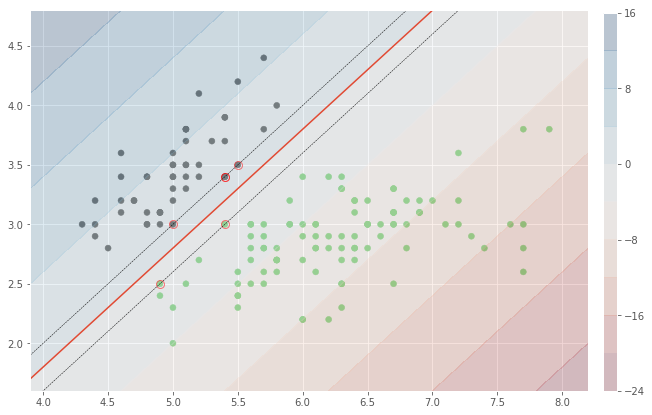

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))
_, pcm = plot_decision(X[:, :2], t, svm_hard, ax=ax, pad=0.4, 
                       grid_step=0.1)
cax = fig.add_axes([0.92, 0.125, 0.02, 0.75])
plt.colorbar(pcm, cax=cax)
plot_boundary(ax, hard_bound);
plot_boundary(ax, hard_bound + sbv(1), 
              linewidth=0.5, linestyle="--", color='k')
plot_boundary(ax, hard_bound - sbv(1), 
              linewidth=0.5, linestyle="--", color='k')

# Soft-margin SVM

The separating boundary depends on very few data points. That is one of the strengths of the algorithm - once the classifier is trained, most of the training set can be forgotten. But what if the support vectors are actually the least reliable points in the training set? This doesn't seem too far fetched, since by definition, they are close to the boundary, hence are in some sense, extreme observations. Our classifier doesn't look very robust to noise.

Enter the soft-margin SVM. We're still in the 60'[s](http://svms.org/history.html). Hendrix just released Electric Ladyland. Woodstock is just around the corner.

To make the classifier more robust, we're going to have to modify the objective somewhat. A large margin is still clearly desirable; this is going to keep the separating hyperplane as far as possible from both classes, so future points will more likely fall on the correct side. But in order to alleviate the large impact of some possibly noisy measurements, we'll have to redefine _margin_ somewhat. Maybe if one or few points from the dataset were ignored, we could find a larger margin hyperplane. Of course, we won't just ignore them completely, only to some extent. How much we choose to ignore any observation will be quantified by an extra variable, $\xi_n$, which will measure how far any data point lies on the _wrong_ side of the margin. We'll keep track of this extent, which we'll call _total slack_, and we'll also try to keep it low, by adding it to the objective of the minimisation. 

The new goal is to maximise the margin while minimising the total amount of slack:

$$\text{minimise} \quad C \sum\limits_{n=1}^N \xi_n + \dfrac{1}{2} \|\mathbf{w} \|^2,$$

subject to the constraints:
$$t_n y(\mathbf{x}_n) \geq 1 - \xi_n, \quad n=1 \dots N$$
where $\xi_n \geq 0, n=1 \dots N$ are the slacks associated with each training vector.

The parameter $C > 0$ is controlling the total amount of slack. Higher values of $C$ will penalise slack more heavily and the classifier will try to adjust the boundary more aggressively, possibly by paying too much attention to outliers, while lower values of $C$ will allow the classifier to focus more on achieving a larger margin, at the price of incurring a larger amount of slack with respect to this boundary.

Using the Lagrange formulation, the objective to minimise becomes:
$$
L(\mathbf{w}, b, \mathbf{a}) = C \sum\limits_{n=1}^N \xi_n + \dfrac{1}{2}\|\mathbf{w}\|^2 - \sum\limits_{n=1}^{N} a_n \{t_n (\mathbf{w}^T \mathbf{x}_n + b) - 1\} - \sum\limits_{n=1}^{N} \mu_n \xi_n
$$
with $a_n \geq 0, \xi_n \geq 0, \mu_n \geq 0 \quad \forall n$.

The critical points of the objective obey:

$$
\begin{align*}
\mathbf{w} &= \sum\limits_{n=1}^N a_n t_n \mathbf{x}_n\\
0          &= \sum\limits_{n=1}^N a_n t_n\\
a_n        &= C - \mu_n
\end{align*}
$$

Eliminating $\mathbf{w}$, $b$ and the $\xi_n$ from the objective gives us the _dual representation_:

$$
\tilde{L}(\mathbf{a}) = \sum\limits_{n=1}^{N} a_n - \dfrac{1}{2} \sum\limits_{n=1}^N\sum\limits_{m=1}^N a_n a_m t_n t_m \mathbf{x}_n^T \mathbf{x}_m
$$
which depends only on $\mathbf{a}$. 

The optimisation is now a maximisation (the optimum is a saddle point with respect to the complete variable set), subject to the constraints:

$$
\begin{align}
   0 \leq a_n                       &\leq C, \quad  n=1 \dots N\\
   \sum\limits_{n=1}^N a_n t_n &= 0
\end{align}
$$


In order to conform to the [cvxopt](http://cvxopt.org/userguide/coneprog.html) API:

![](http://cvxopt.org/userguide/_images/math/4a1d5a88630fc2310b16135d0ae191d396ebae9e.png)

we'll write the equality constraint `Ax=b` as $\mathbf{t}^T \mathbf{a} = 0$, where $\mathbf{t}$ is the target vector, and $\mathbf{a}$ is the vector of Lagrange multipliers. Similarly, the inequality constraints `Gx <= h` will correspond to $
  \begin{bmatrix}
    -\mathbf{I} \\
     \mathbf{I}
  \end{bmatrix} \left[ \quad \mathbf{a} \quad \right]
  \leq 
  \begin{bmatrix}
    \mathbf{0} \\
    \mathbf{C}
  \end{bmatrix} 
$, where $\mathbf{I}$ is the identity matrix, and $\mathbf{0}$ and $\mathbf{C}$ are $n$-vectors having all components equal to $0$ and $C$, respectively.

As before, we'll write the whole logic in a simple class, endowed with a `fit` and `predict` method.

In [8]:
class LinearSVM:
    def __init__(self, tol=1e-4):
        self.tol = tol # tol for non-zero Lagrange multipliers
        
    def fit(self, X, t, C=1, verbose=False):
        """
        Note: Uses cvxopt.solvers.qp to solve the dual representation
              The unknown vector `x` corresponds to `a`.
              The available equality constraint Ax=b, is associated
                  with sum(a_n*t_n) = 0, i.e. t^T @ a = 0,
                      where A = transpose(t).
              The inequality constraint Gx <= h is associated 
                  with the box constraints
                  0 <= a_n <= C: -I * a <= 0  and  I * a <= C 
                  which must be stacked in order to be expressed as
                  [-I ] * a <= [ 0 ]
                  [ I ]        [ C ]
        """
        cvx.solvers.options['show_progress'] = verbose
        t = t.reshape(-1, 1)
        N = len(t)
        P = cvx.matrix((t @ t.T) * (X @ X.T), tc='d')
        q = cvx.matrix(-np.ones((N, 1)))
        A = cvx.matrix(t.T, tc='d') 
        b = cvx.matrix(0, tc='d')
        G = cvx.matrix(np.r_[-np.identity(N),  np.identity(N)])
        h = cvx.matrix(np.r_[np.zeros((N, 1)),  np.ones((N, 1)) * C])
        res = cvx.solvers.qp(P, q, G, h, A, b) # solve
        a = np.array(res['x']) # the Lagrange multipliers
        sv_idx = ~np.isclose(a, 0.0, atol=self.tol).ravel()
        a[~sv_idx] = 0 # set to zero all a's which are self.tol near 0
        a[np.isclose(a, C, atol=self.tol)] = C # same for the upper end

        self.X_sv = X_sv = X[sv_idx]
        self.a_sv = a_sv = a[sv_idx]
        self.t_sv = t_sv = t[sv_idx]
        self.w = X_sv.T @ (a_sv * t_sv)
        
        # average over the support vectors with a < C.
        svc_idx = (a_sv != C).ravel()
        M = np.sum(svc_idx) # number of support vectors on the boundary
        self.b = np.mean(t_sv[svc_idx].T - 
                         (a_sv * t_sv).T @ X_sv @ X_sv[svc_idx].T)
        self.C = C # save the slack parameter as an instance variable
        if verbose:
            print(f"# supp. vectors: {len(X_sv)}")
            print(f"# supp. vectors on the correct side: {M}")
        return np.r_[[[self.b]], self.w]
        
    def score(self, X):
        return (self.a_sv * self.t_sv).T @ (self.X_sv @ X.T) + self.b
    
    def predict(self, X):
        return np.sign(self.score(X))

In [9]:
# Let's test this
lsvm = LinearSVM(tol=1e-5)
lsvm.fit(X, t, C=1, verbose=True);

     pcost       dcost       gap    pres   dres
 0: -1.2101e+01 -2.9093e+02  2e+03  3e+00  1e-13
 1: -5.7647e+00 -1.5297e+02  3e+02  3e-01  1e-13
 2: -3.4109e-01 -2.5109e+01  4e+01  4e-02  5e-14
 3: -3.3958e-02 -2.4104e+00  3e+00  1e-03  2e-14
 4: -4.2693e-01 -9.5820e-01  6e-01  2e-04  1e-14
 5: -5.0876e-01 -1.0174e+00  5e-01  2e-04  1e-14
 6: -7.1362e-01 -7.7382e-01  6e-02  1e-05  2e-14
 7: -7.4289e-01 -7.4401e-01  1e-03  2e-07  2e-14
 8: -7.4349e-01 -7.4350e-01  1e-05  2e-09  2e-14
 9: -7.4349e-01 -7.4349e-01  1e-07  2e-11  2e-14
Optimal solution found.
# supp. vectors: 3
# supp. vectors on the correct side: 3


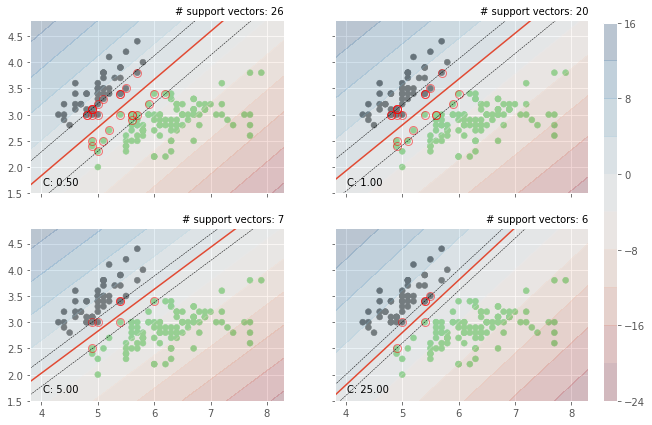

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7),
                         sharex=True, sharey=True)
clf = LinearSVM()
for ax, C in zip(axes.ravel(), [0.5, 1, 5, 25]):
    w = clf.fit(X[:, :2], t, C=C, verbose=False)
    ax, pcm = plot_decision(X[:, :2], t, clf, ax=ax, grid_step=0.1)
    plot_boundary(ax, w)
    plot_boundary(ax, w + sbv(1), 
                  linewidth=0.5, linestyle="--", color='k')
    plot_boundary(ax, w - sbv(1), 
                  linewidth=0.5, linestyle="--", color='k')
    atit =  f"# support vectors: {len(clf.X_sv)}"
    ax.set_title(atit, ha="right", fontsize=10, loc='right')
cax = fig.add_axes([0.92, 0.125, 0.02, 0.75])
plt.colorbar(pcm, cax=cax);

The trade-off between the large margin and the total amount of slack is clearly visible.

# Kernel SVMs

We made _some_ progress. But what if our dataset is not linearly separable? If it's close to being linearly separable, we could adjust C using cross-validation, and get a boundary that would do a decent job. What if the dataset is _utterly_ non-separable? What if one of the classes completely surrounds the other? 

Enter kernel SVMs. We're in the 90's now. Music died a long time ago.

The new idea is straightforward - it only took about two decades to arrive at. If the dataset is not linearly separable in the original coordinates, project it into a new space (usually with larger dimensionality) where the linear separation is possible. The strength of the method relies on one particular aspect of the formulation: both the objective and the actual classification involve only dot products. Instead of coming up with a suitable transformation, and then taking the dot products of the images, $\mathbf{\phi}(\mathbf{x})^T \mathbf{\phi}(\mathbf{z})$, maybe we can find a function - a _kernel_ - that would compute the dot products directly. A real valued function $k(\mathbf{x}, \mathbf{z})$ is a _valid kernel_ if there exists a corresponding feature space, such that $k(\mathbf{x}, \mathbf{z}) = \mathbf{\phi}(\mathbf{x})^T \mathbf{\phi}(\mathbf{z})$. Most of the time we won't know what the feature space actually is, but it won't actually matter either, since we only care about the dot products.

To come up with a valid kernel, we [just](https://en.wikipedia.org/wiki/Mercer%27s_theorem) have to make sure it is [positive semi-definite](https://en.wikipedia.org/wiki/Positive-definite_kernel). Commonly used ones are the polynomial $k_1(\mathbf{x}, \mathbf{z}) = (\mathbf{x}^T \mathbf{z} + 1)^d$  and Gaussian kernel $k_2(\mathbf{x}, \mathbf{z}) = e^{-\|\mathbf{x} - \mathbf{z}\|^2/2\sigma^2}$. 

To come up with new kernels, the easiest way is to combine existing kernels. If we are willing to restrict ourselves to certain types of combinations, the new kernels will also be valid. The composition of a valid kernel with any polynomial with non-negative coefficients is valid. Taking the product of two valid kernels, $k(\mathbf{x}, \mathbf{z}) = k_1(\mathbf{x}, \mathbf{z}) k_2(\mathbf{x}, \mathbf{z})$ also makes a valid kernel, and so does their sum, $k(\mathbf{x}, \mathbf{z}) = k_1(\mathbf{x}, \mathbf{z}) + k_2(\mathbf{x}, \mathbf{z})$.

It's worth mentioning here that even though we are projecting our data into high dimensional feature spaces (indeed, even infinite dimensional for exponential type kernels) we don't actually have to face the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). This is because our projections are actually constrained to lie on lower dimensional subspaces of the feature space. This is especially easy to see for the polynomial kernel: 

\begin{aligned}
k(\mathbf{x}, \mathbf{z}) &= (\mathbf{x}^T \mathbf{z})^2\\
                          &= (x_1 z_1 + x_2 z_2)^2\\
                          &= (x_1^2 z_1^2 + 2x_1 z_1 x_2 z_2 + x_2^2 z_2^2)\\          
                          &= (x_1^2, \sqrt{2}x_1 x_2, x_2^2) \cdot (z_1^2, \sqrt{2}z_1 z_2, z_2^2)\\
\end{aligned}

The projection $(x_1, x_2) \mapsto (x_1^2, \sqrt{2}x_1 x_2, x_2^2)$ associated with this simplified quadratic kernel maps the 2-dimensional input space into a 2-dimensional manifold embedded in 3-dimensional feature space.

To make see this more clearly we can plot a toy dataset consisting of two concentric classes, and it's projection into a 3-dimensional feature space.

In [2]:
points = 2*np.c_[np.random.rand(200), np.random.rand(200)] - 1
c1 = points[np.sum(points**2, 1) < 0.5, :]
c2 = points[np.sum(points**2, 1) > 0.8, :]

In addition to the projection associated with the quadratic polynomial kernel, we'll also use a custom transformation: $(x_1, x_2) \mapsto (x_1, x_2, x_1^2 + x_2^2)$ which does an ever better job of creating separation between the classes. For this toy dataset this is easy to find, but for high-dimensional, real-world datasets we'll have to rely on kernels for back-door access to the feature spaces where the classes are closer to being linearly separable.

In [3]:
phi1 = lambda X: X[:, [0]]**2 + X[:, [1]]**2
phi2 = lambda X: X[:, [0]] * X[:, [1]] * np.sqrt(2)

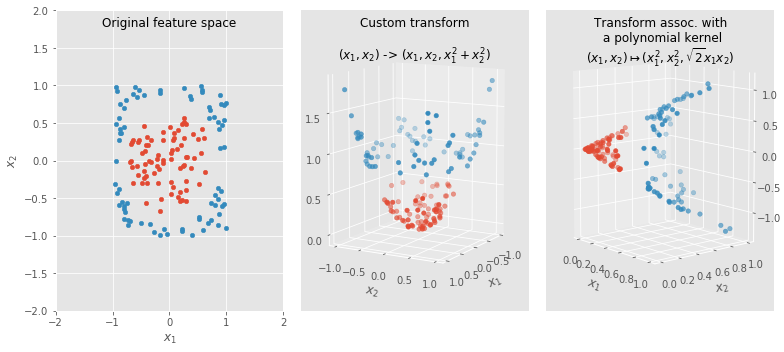

In [8]:
plot_transform(c1, c2, phi1, phi2)

As a final remark, the projection is _usually_ onto higher dimensional feature spaces, but it doesn't _have_ to be. For our toy dataset we could have achieved perfect separation even projecting _down_ to a 1-dimensional feature space: $(x_1, x_2) \mapsto x_1^2 + x_2^2$. Of course, we won't be usually this lucky.

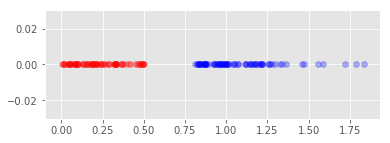

In [28]:
def plot_transf_1d(c1, c2):
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.scatter(c1[:, 0]**2 + c1[:, 1]**2, np.zeros(len(c1)),  
             marker='o', color='r', alpha=0.3)
    ax.scatter(c2[:, 0]**2 + c2[:, 1]**2, np.zeros(len(c2)),  
             marker='o', c='b', alpha=0.3)
plot_transf_1d(c1, c2)

We'll manage different kernels through their associated _Gram_ matrices. These matrices hold the evaluation of the kernel on all pairs of vectors of interest.

In [11]:
def kernel(X, Z, kind='linear', **kwargs):
    """
    Parameters:
    X: array
        Input matrix, vectors x as rows.
    Y: array 
        Input matrix, vectors z as rows.
    kwargs:
        Optional parameters.
    Returns
    -------
    array
        Gram matrix containing k(x, z), for each input (x, z) pair
    """
    if kind == 'linear':
        A = kwargs.get('A')
        if A is None:
            A = np.identity(X.shape[1])
        return X @ A @ Z.T
    if kind == 'poly':
        d = kwargs.get('degree', 2)
        return np.power(X @ Z.T + 1, d)
    # radial basis kernels
    dist2 = np.sum(np.power(X[:, None, :] - Z[None, :, :], 2), axis=2)
    s = kwargs.get('sigma', 1)
    if kind == 'rbf':
        return np.exp(-dist2 / (2 * s**2))
    if kind == 'ou': # Ornstein-Uhlenbeck
        return np.exp(-np.sqrt(dist2) / s**2)
    if kind == 'expo':
        return np.exp(np.exp(-dist2 / s**2))
    # alternative way of computing the squared norm of the difference
    if kind == 'rbf_':
        X2 = np.power(X, 2).sum(1).reshape(-1, 1)
        Z2 = np.power(Z, 2).sum(1)
        dist2 = X2 + Z2.T - 2*X @ Z.T
        return np.exp(-dist2 / (2 * s**2))

Using the transformed dataset the objective becomes:
$$
L(\mathbf{w}, b, \mathbf{a}) = C \sum\limits_{n=1}^N \xi_n + \dfrac{1}{2}\|\mathbf{w}\|^2 - \sum\limits_{n=1}^{N} a_n \{t_n (\mathbf{w}^T \mathbf{\phi}(\mathbf{x}_n) + b) - 1\} - \sum\limits_{n=1}^{N} \mu_n \xi_n
$$
with $a_n \geq 0, \xi_n \geq 0, \mu_n \geq 0 \quad \forall n$.

The critical points of the objective satisfy:

$$
\begin{align*}
    \mathbf{w} &= \sum\limits_{n=1}^N a_n t_n \mathbf{\phi}(\mathbf{x}_n)\\
    0          &= \sum\limits_{n=1}^N a_n t_n\\
    a_n        &= C - \mu_n
\end{align*}
$$

The dual representation contains now only evaluations of the kernel function:
$$
\tilde{L}(\mathbf{a}) = \sum\limits_{n=1}^{N} a_n - \dfrac{1}{2} \sum\limits_{n=1}^N\sum\limits_{m=1}^N a_n a_m t_n t_m k(\mathbf{x}_n, \mathbf{x}_m)
$$

\begin{align}
   0 \leq a_n                       &\leq C, \quad  n=1 \dots N\\
   \sum\limits_{n=1}^N a_n t_n &= 0
\end{align}

Let's take a look at the Gram matrix for the Gaussian kernel.

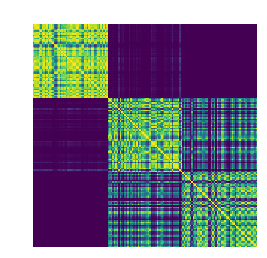

In [12]:
plt.matshow(partial(kernel, kind='rbf', sigma=1)(X, X))
plt.axis('off');

The clear separation between the two classes (i.e. between _setosa_ and the {_versicolor_, _virginica_}) conglomerate is clearly distinguishable in the "activation patches" of the Gram matrix.

To accommodate the use of kernels, we only need to make minor adjustments our previous `LinearSVM` class.

In [13]:
class SVM:
    def __init__(self, kind='linear', tol=1e-2, **kernel_kwargs):
        self.kernel = partial(kernel, kind=kind, **kernel_kwargs)
        self.tol = tol # tol. for non-zero Lagrange multipliers
        
    def fit(self, X, t, C=1, verbose=False):
        """
        Note: Uses cvxopt.solvers.qp to solve the dual representation
              of the maximum margin problem.
              The unknown vector `x` corresponds to `a`.
              The available equality constraint Ax=b, is assoc. with 
                  sum(a_n*t_n) = 0, i.e. t^T @ a = 0, 
                  where A = transpose(t).
              The inequality constraint Gx <= h is assoc. with 
              the box constraints
                  0 <= a_n <= C: -I * a <= 0  and  I * a <= C 
                  which must be stacked in order to be expressed as
                  [-I ] * a <= [ 0 ]
                  [ I ]        [ C ]
        """
        cvx.solvers.options['show_progress'] = verbose
        N = len(t)
        K = self.kernel(X, X)
        P = cvx.matrix(t @ t.T * K, tc='d')
        q = cvx.matrix(-np.ones((N, 1)))
        A = cvx.matrix(t.T, tc='d') 
        b = cvx.matrix(0, tc='d')
        G = cvx.matrix(np.r_[-np.identity(N),  np.identity(N)])
        h = cvx.matrix(np.r_[np.zeros((N, 1)),  np.ones((N, 1)) * C])
        res = cvx.solvers.qp(P, q, G, h, A, b) # solve
        a = np.array(res['x']) # Lagrange multipliers
        sv_idx = ~np.isclose(a, 0.0, atol=self.tol).ravel() 
        a[~sv_idx] = 0
        a[np.isclose(a, C, atol=self.tol)] = C

        self.X_sv = X_sv = X[sv_idx]
        self.a_sv = a_sv = a[sv_idx]
        self.t_sv = t_sv = t[sv_idx]
        self.w = X_sv.T @ (a_sv * t_sv)
        
        svc_idx = (a_sv != C).ravel()
        self.X_svc = X_svc = X_sv[svc_idx] # sup. vecs. on the boundary
        # average over the support vectors with a < C to get b
        self.b = np.mean(t_sv[svc_idx].T - 
                         (a_sv * t_sv).T @ self.kernel(X_sv, X_svc))
        self.C = C # save the slack parameter as an instance variable

    def score(self, X):
        score = (self.a_sv * self.t_sv).T @ self.kernel(self.X_sv, X)
        score += self.b
        return score
    
    def predict(self, X):
        return np.sign(self.score(X)).squeeze()

We'll need a non-separable dataset. We'll use the `make_moons` function from the only python package which a dash in its name.

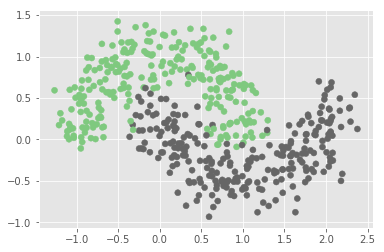

In [14]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=.2)
t = y.reshape(-1, 1)
t[t==0] = -1 # it's easier to have the classes labelled +1 and -1.
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.Accent);

Let's try out some of the kernels we've implemented.

In [15]:
def plot_classifications(X, t, par, cvals=(0.1, 1, 5, 35)):
    tstr = dict(rbf="Gaussian", poly="Polynomial", 
                expo="Exponential", ou="Ornstein-Uhlenbeck")
    fig, axes = plt.subplots(2, 2, figsize=(10, 7), 
                             sharex=True, sharey=True)
    clf = SVM(**par)
    for ax, C in zip(axes.ravel(), cvals):
        clf.fit(X, t, C=C, verbose=False)
        ax, pcm = plot_decision(X, t, clf, ax=ax, grid_step=0.1)
        atit =  f"# support vectors: {len(clf.X_sv)}\n"
        atit += f"# support vectors on the boundary: {len(clf.X_svc)}"
        ax.set_title(atit, ha="right", fontsize=10, loc='right')
    cax = fig.add_axes([0.92, 0.125, 0.02, 0.75])
    kpar = "sigma" if "sigma" in par else "degree"
    title = f"{tstr[par['kind']]} kernel with {kpar} {par[kpar]}"
    fig.suptitle(title, fontsize=14)
    plt.colorbar(pcm, cax=cax)

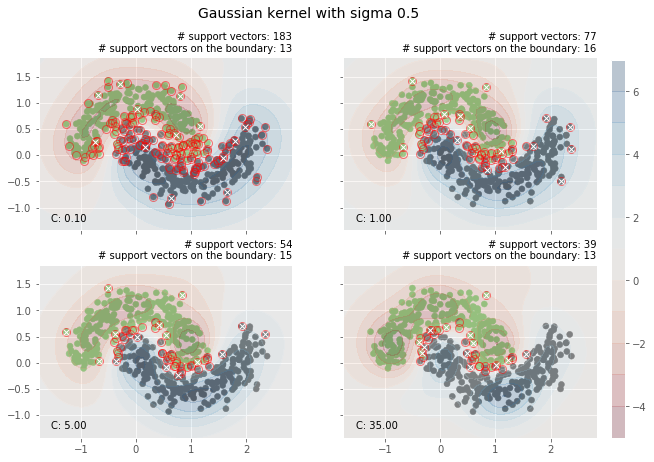

In [17]:
plot_classifications(X, t, par=dict(kind='rbf', sigma=0.5))

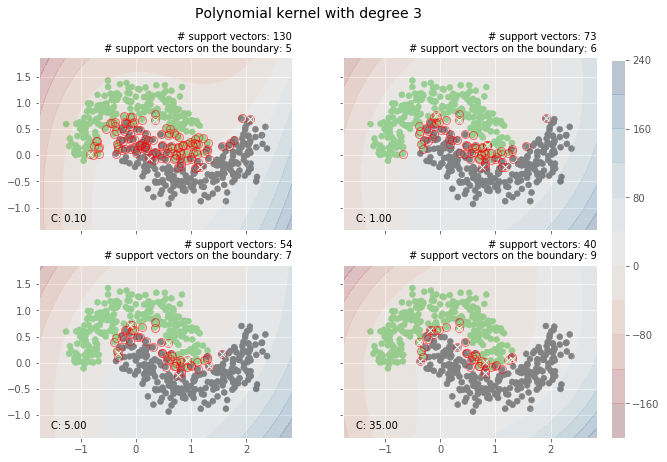

In [18]:
plot_classifications(X, t, par=dict(kind='poly', degree=3))

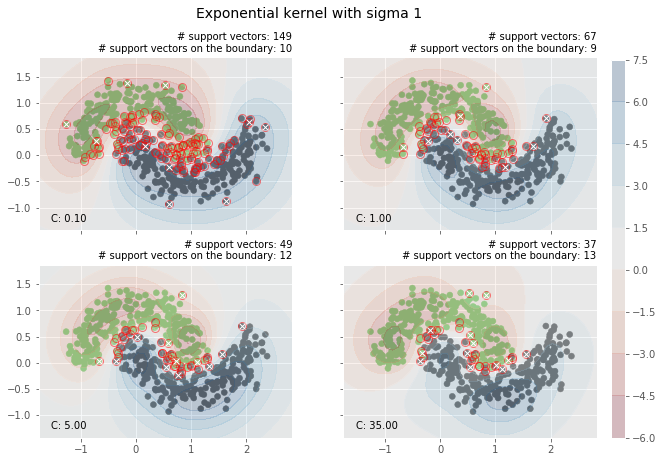

In [19]:
plot_classifications(X, t, par=dict(kind='expo', sigma=1))

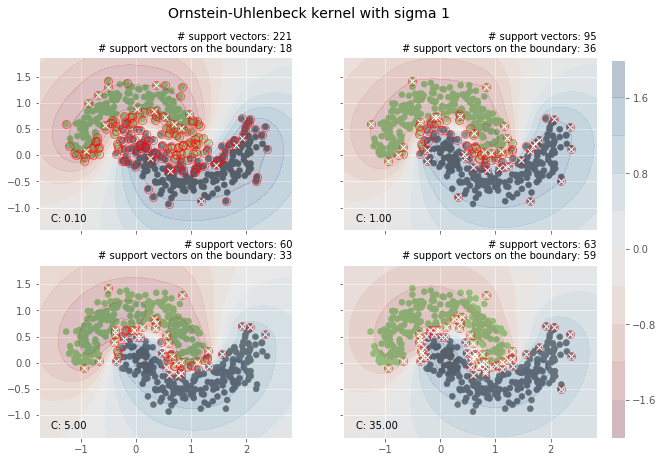

In [20]:
plot_classifications(X, t, par=dict(kind='ou', sigma=1))

Things to notice: the range of values for the size of the kernel (for radial basis kernels) are not far from 1. This is because the the separating boundary is not unreasonably 'wiggly', and our data is normalised (like it should!).
Since both the size of the kernel and the $C$ value have an effect on the flexibility of the decision boundary, there's an obvious interplay between them. Let's explore this a little.

We'll look at the test set performance of a Gaussian kernel SVM, on a grid of plausible values for the kernel width and for the $C$ parameter.

In [21]:
from scipy.ndimage import zoom
def plot_cs(X, t):
    train_idx = np.random.binomial(1, 0.6, len(t)).astype(bool)
    X_train, t_train = X[ train_idx], t[train_idx]
    X_test,  t_test  = X[~train_idx], t[~train_idx]

    cvals = np.linspace(0.5, 50, 30)
    svals = np.linspace(0.05, 3, 30)
    cgrid, sgrid = np.meshgrid(cvals, svals)
    csgrid = np.c_[cgrid.ravel(), sgrid.ravel()]
    res = np.zeros(len(csgrid))
    for i, (C, sigma) in enumerate(csgrid):
        clf = SVM(kind='rbf', sigma=sigma)
        clf.fit(X_train, t_train, C=C, verbose=False)
        res[i] = np.mean(clf.predict(X_test) == t_test.ravel())
    fig, ax = plt.subplots(figsize=(9, 7))
    # interpolate with cubic splines for increased smoothness
    acc = zoom(res.reshape(cgrid.shape), 3)
    cgrid = zoom(cgrid, 3)
    sgrid = zoom(sgrid, 3)
    cplot = plt.contourf(cgrid, sgrid, acc, 10)
    cax = fig.add_axes([0.92, 0.125, 0.02, 0.75])
    plt.colorbar(cplot, cax=cax)
    ax.set(xlabel='C', ylabel=r'$\sigma$', title="Test set accuracy")

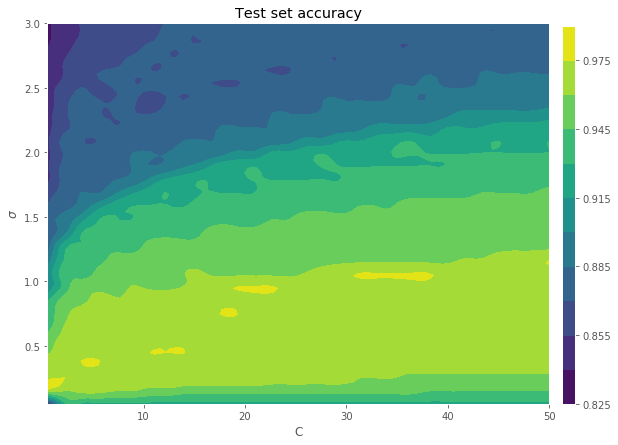

In [22]:
plot_cs(X, t)

As you can see, there is a large domain of $(C, \sigma)$ pairs where the test set accuracy is optimal, at least for our toy moons data set.

We're finally back in the present. 

<!--There's 'new' music now, on hand-held devices powered by Deep Learning; toddlers play with [DCGAN](https://arxiv.org/abs/1511.06434v2)s, using [RL](https://twitter.com/yoavgo/status/877727079587921920) agents to improve them. 
-->

SVM's are no longer the rage, but are still commonly used for specific tasks, like outlier detection. We're going to look at that in the next post.